# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of limonene+water+ethanol

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [5]:
import numpy as np
from scipy.constants import R

In [6]:
#fited parameters
# chafer's

alpha12=alpha13=alpha23=alpha21=alpha31=alpha23=0.2;


A12=107.99
A21=555.81
A13=1011.98
A31=2277.37
A23=-1113.1
A32=1217.37

alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A = np.array([[0, A12, A13],
             [A21, 0, A23],
             [A31, A32, 0]])

In [7]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    #note that we used many lines for didatics
    #we can do it in few lines:
    #note that some expression occur more than once below
    #so it may be useful define it as a intermediary recurrent term here
    #and calculate it once to use it then several times
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [8]:
#test it to see that the results are the same
T=293.15
x=np.array([.2,.3,.5]) #normalized
x_as_column = np.array([x]).T
print(Gamma(T,x_as_column,alpha,A)) #test using those trial input

[[ 7.97865398]
 [ 0.31550702]
 [ 0.95773617]]


# Liq-Liq Equilibria Flash
The next step will be using the model in a phase equilibria algorithm, a Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z


XXX img src from thesis XXX
* ...............  =>guess, xL1 xL2, then calls model(T,P,x)
* ...............//
* .............<=
* T,P,z => algorithm => finds equilibrium xL1 xL2 and BETA

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

# algorithm


In [9]:
def ELLflash_explicit(Z,beta0,K0,MODEL):
    beta=prevbeta=beta0
    K=prevK=K0
    
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or (max(abs(K-prevK))>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations
        
        #Solve RachfordRice equation with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or (abs(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            F=0
            for j in range(3):
                F+=Z[j]*a[j]

            J=0
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= F/J

            looping3 = looping3 + 1        

        prevK = K
        
        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI)
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII)
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i])
                       
        looping2 = looping2 + 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=0.2966

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest*1
k0=ktest*1
Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)
ans=ELLflash_explicit(Z,beta0,k0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[ 0.05349958  0.52504064  0.42145977]
[ 0.88449314  0.10350801  0.01199885]
[ 0.29663337]
1


In [10]:
%timeit ans=ELLflash_explicit(Z,beta0,k0,MODEL)

10000 loops, best of 3: 185 µs per loop


In [11]:
def ELLflash(Z,beta0,K0,MODEL): #ELLflash_linalg
    beta=prevbeta=beta0
    K=prevK=K0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((np.linalg.norm(K-prevK))>0.0001 # convergence criteria
               and looping2 < 1000) ): # max number of iterations
        looping3 = 0
        while ( (looping3 == 0)
               or (np.linalg.norm(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)
            
            looping3 += 1        

        prevK = K
        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI)
        
        XII = K*XI

        gamaII = MODEL(XII)
        
        K = (gamaI)/(gamaII)
                       
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

In [12]:
%timeit ans=ELLflash(Z,beta0,k0,MODEL)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans)

The slowest run took 11460.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 154 µs per loop
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)


In [13]:
@jit(nopython=True)
def ELLflash_fast(Z,beta0,K0,alpha,A):
    beta=beta0.copy()
    prevbeta=beta.copy()
    K=K0.copy()
    prevK=K.copy()
    XI=Z.copy()
    XII=Z.copy()
    looping2=0
    looping3=0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((np.linalg.norm(K-prevK))>0.0001 # convergence criteria
               and looping2 < 1000) ): # max number of iterations
        looping3 = 0
        while ( (looping3 == 0)
               or (np.linalg.norm(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)
            
            looping3 += 1        

        prevK = K
        XI = (1./(1+beta * (K-1))) * Z

        gamaI = Gamma(T,XI,alpha,A)
        
        XII = K*XI

        gamaII = Gamma(T,XII,alpha,A)
        
        K = (gamaI)/(gamaII)
                       
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

In [14]:
BETA0=np.array([[beta0]])
%timeit ans=ELLflash_fast(Z,BETA0*1.5,k0,alpha,A)
#ans=ELLflash_fast(Z,BETA0*1.5,k0,alpha,A)
#print(Z,BETA0,k0,alpha,A)
print(ans)
#print(ans[0])

The slowest run took 39072.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 93.2 µs per loop
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)


In [54]:
from scipy import optimize as opt

def ELLflash_sci(Z,beta0,K0,MODEL):
        
    #prepare FP input
    def fix(kxixiibeta):
        #local varaibles translation
        K=np.array([kxixiibeta[0:3]]).T
        beta0 = np.array([[kxixiibeta[9]]])
        
        #prepare NR input
        F = lambda beta, K=K, Z=Z: (Z.T @ ((1/(1+beta*(K-1))) * (K-1)))
        J = lambda beta, K=K, Z=Z: -(((Z.T*((1/(1+beta*(K-1))) * (K-1)).T) @ ((1/(1+beta*(K-1))) * (K-1))))
        
        #run NR
        beta = opt.newton(func=F,x0=beta0,fprime=J,tol=1e-5, maxiter=50)
        
        #run XI, gammaI, XII, gammaII
        XI = (1./(1+beta * (K-1))) * Z
        gamaI = MODEL(XI)
        XII = K*XI
        gamaII = MODEL(XII)
        
        #prepare return-format solution
        return np.concatenate( ( ((gamaI)/(gamaII))[0:,0], XI[0:,0], XII[0:,0], beta[0:,0] ), axis=0 )
    
    #prepare FP input
    point0 = np.concatenate( ( K0[0:,0], np.zeros(3), np.zeros(3), beta0[0:,0] ), axis=0 )

    #sanity check
    if np.isnan(point0).any() or np.isinf(point0).any():
        print('nans or infs here')
        raise ValueError
    
    #run FP    
    point = opt.fixed_point(func = fix, x0 = point0, xtol=1e-08, maxiter=500)
    
    #prepare return-format solution
    K = np.array([point[0:3]]).T
    XI = np.array([point[3:6]]).T
    XII = np.array([point[6:9]]).T
    beta = np.array([point[9:10]]).T
    converged=1
    
    return XI, XII, beta, converged

ans=ELLflash_sci(Z,BETA0*1.4,k0*1.1,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]
[[ 0.88451549]
 [ 0.10349176]
 [ 0.01199276]]
[[ 0.29661078]]
1


In [16]:
ans=ELLflash_sci(Z,BETA0*1.5,k0*1.1,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]
[[ 0.88451549]
 [ 0.10349176]
 [ 0.01199276]]
[[ 0.29661078]]
1


In [17]:
BETA0=np.array([[beta0]])
%timeit ans=ELLflash_sci(Z,BETA0,k0,MODEL)
print(Z,BETA0,k0,alpha,A)
print(ans)
print(ans[0])

1000 loops, best of 3: 1.16 ms per loop
[[ 0.3]
 [ 0.4]
 [ 0.3]] [[ 0.2966]] [[ 16.52779552]
 [  0.1971144 ]
 [  0.02845599]] [[ 0.   0.2  0.2]
 [ 0.2  0.   0.2]
 [ 0.2  0.2  0. ]] [[    0.     107.99  1011.98]
 [  555.81     0.   -1113.1 ]
 [ 2277.37  1217.37     0.  ]]
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)
[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]


In [18]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=0.2966

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest*1
k0=ktest*1
Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.05351624]
 [ 0.52503406]
 [ 0.4214497 ]]
[[ 0.88451339]
 [ 0.10349332]
 [ 0.01199329]]
[[ 0.29661204]]
1


In [19]:
%timeit ans=ELLflash(Z,beta0,k0,MODEL)

1000 loops, best of 3: 762 µs per loop


# initial guess


In [20]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)
    X0 = Z
    gama0 = MODEL(X0)
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin)

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    nI0 = (KlinMax - Klin) * Z

    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0)

    nII0=(Klin-KlinMin) * Z

    XII0=1/(np.sum(nII0)) * nII0;

    gamaII0=MODEL(XII0)

    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    K0 = (gamaI0)/(gamaII0)

    return beta0, K0

In [21]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T
betatest=0.2966
xitest=np.array([[0.0535,
0.5250,
0.4215]]).T
xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T
ktest=1/(xitest/xiitest)

###

Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)

iguesses = iguess(Z,MODEL)

beta0 = iguesses[0]
K0 = iguesses[1]

print(beta0)
print(K0)

ans=ELLflash(Z,beta0,K0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.39441162]]
[[ 35.40198618]
 [  0.21977285]
 [  0.14735411]]
[[ 0.05351532]
 [ 0.52503359]
 [ 0.42145109]]
[[ 0.88450404]
 [ 0.10350028]
 [ 0.01199568]]
[[ 0.29661616]]
1


# grid calc plot

In [58]:
Z1 = np.linspace(0,1,10)
Z2 = np.linspace(0,1,10)
Z3 = np.linspace(0,1,10)

Z1[0]=1e-9
Z2[0]=1e-9
Z3[0]=1e-9
Z1[-1]=1-1e-9
Z2[-1]=1-1e-9
Z3[-1]=1-1e-9

rawZs = np.ndarray((10,10), dtype=object)

flags = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        rawZs[i,j]=np.array([Z1[i],Z2[j],1-Z1[i]-Z2[j]])
        if ( rawZs[i,j][0] + rawZs[i,j][1] +  rawZs[i,j][2] == 1 ):
            flags[i,j] = 1
            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([3,npts])
Resultados_XI = np.zeros([3,npts])
Resultados_XII = np.zeros([3,npts])

l=0
for k in range(npts):
    MODEL = lambda x: Gamma(T,x,alpha,A)
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    #ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    #http://www.scipy-lectures.org/intro/language/exceptions.html
    
    if np.isnan(beta0) or np.isnan(K0).any():
        pass
    else:

        try:
            ans = ELLflash_sci(np.array([Zs[k]]).T,beta0,K0,MODEL)

            #succeeds:

            if (0<ans[2] and 1>ans[2] and ans[3]==1):
                #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
                Resultados_XI[:,l] = np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
                Resultados_XII[:,l] = np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
                Resultados_beta[l] = ans[2]
                Resultados_conv[l] = ans[3]
                print(ans[3], ans[2])
                l+=1

        except RuntimeError:
            print('no converge here')
            
        except ValueError:
            print('no converge here')

        finally:
            print('k++')





print('done',l)
    
ndone=l-1

89
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
1 [[ 0.11179906]]
k++
1 [[ 0.1085514]]
k++
1 [[ 0.10108961]]
k++
no converge here
k++
1 [[ 0.0446654]]
k++
no converge here
k++
no converge here
k++
1 [[ 0.22367347]]
k++
1 [[ 0.22319447]]
k++
no converge here
k++
no converge here
k++
no converge here
k++
1 [[ 0.16480273]]
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
1 [[ 0.33554788]]
k++
no converge here
k++
no converge here
k++
no converge here
k++
1 [[ 0.3355386]]
k++
1 [[ 0.3233495]]
k++
no converge here
k++
no converge here
k++
no converge here
k++
no converge here
k++
1 [[ 0.55257771]]
k++
no converge here
k++
no converge here
k++
1 [[ 0.47190665]]
k++
1 [[ 0.52956105]]
k++
no converge here
k++
no converge here
k++
nans or infs here
no converge here
k++
no converge here
k++
no c

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in multiply
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


In [59]:
fResultados_XI = Resultados_XI[:,np.where(Resultados_conv==1)]
fResultados_XII = Resultados_XII[:,np.where(Resultados_conv==1)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv==1)]

In [60]:
print(Resultados_XI[:,3]) #ERRADO AQUI

[ 0.07702471  0.57482405  0.34815124]


In [61]:
print(fResultados_XI[:,0,3]) #ERRADO AQUI

[ 0.07702471  0.57482405  0.34815124]


In [65]:
test_data1 = np.zeros([ndone,3])
test_data2 = np.zeros([ndone,3])

from matplotlib import pyplot as plt

for k in range(ndone):
    #print(Resultados_XI[:,0])
    test_data1[k,0:3] = fResultados_XI[:,0,k]
    test_data2[k,0:3] = fResultados_XII[:,0,k]
    #test_data[l,3] = GM[l]

print(test_data1[:,:])
    
a=test_data1[:,0]
b=test_data1[:,1]



[[  7.48370008e-05   1.12524827e-09   9.99925162e-01]
 [  5.06591277e-03   2.47727884e-01   7.47206203e-01]
 [  1.58933398e-02   3.66775725e-01   6.17330935e-01]
 [  7.70247149e-02   5.74824048e-01   3.48151237e-01]
 [  7.48370011e-05   1.28648716e-09   9.99925162e-01]
 [  1.30276003e-03   1.42079784e-01   8.56617456e-01]
 [  1.14258466e-01   6.24348866e-01   2.61392668e-01]
 [  7.48370015e-05   1.50166324e-09   9.99925161e-01]
 [  8.57318564e-02   5.88976023e-01   3.25292121e-01]
 [  1.86215592e-01   6.65385712e-01   1.48398696e-01]
 [  9.93252015e-01   7.93301105e-12   6.74798527e-03]
 [  5.69172496e-02   5.33542016e-01   4.09540734e-01]
 [  1.46831071e-01   6.49802893e-01   2.03366036e-01]
 [  9.93252015e-01   9.92684880e-12   6.74798526e-03]
 [  9.83072115e-01   1.16800539e-02   5.24783149e-03]
 [  1.03505402e-01   6.12725851e-01   2.83768747e-01]
 [  9.93252015e-01   1.32593877e-11   6.74798526e-03]
 [  9.72894280e-01   2.16028501e-02   5.50286946e-03]
 [  8.72647562e-01   1.14223

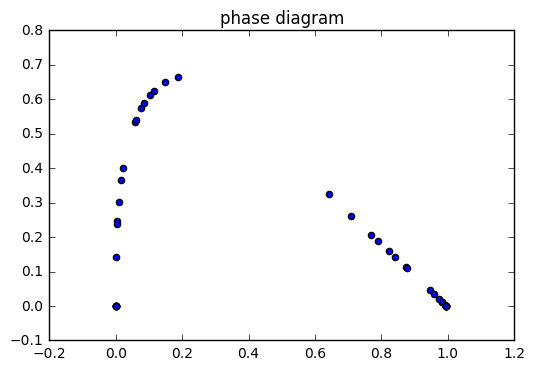

In [66]:

# barycentric coords: (a,b,c)
a=test_data1[:,0]
b=test_data1[:,1]
c=test_data1[:,2]

d=test_data2[:,0]
e=test_data2[:,1]
f=test_data2[:,2]

# create a triangulation out of these points
#Tri = tri.Triangulation(cartx,carty)
#Tri = tri.Triangulation(a,b)

# plot the contour
#plt.tricontourf(cartx,carty,Tri.triangles,v)
#plt.tricontourf(a,b,Tri.triangles,v)


# create the grid
#corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
#corners = np.array([[0, 0], [1, 0], [0,1]])
#triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# creating the grid
#refiner = tri.UniformTriRefiner(triangle)
#trimesh = refiner.refine_triangulation(subdiv=4)

#plotting the mesh
#plt.triplot(trimesh,'k--')

plt.scatter(a,b)
plt.scatter(d,e)
plt.title('phase diagram')
#plt.axis('off')
plt.show()

In [67]:
#determinar pto crítico
xcrit=0.4 #aprox.


#refiltrar a e b

al=a[np.where(a<=0.4)]
ar=a[np.where(a>0.4)]
dl=d[np.where(d<=0.4)]
dr=d[np.where(d>0.4)]

bl=b[np.where(a<=0.4)]
br=b[np.where(a>0.4)]
el=e[np.where(d<=0.4)]
er=e[np.where(d>0.4)]

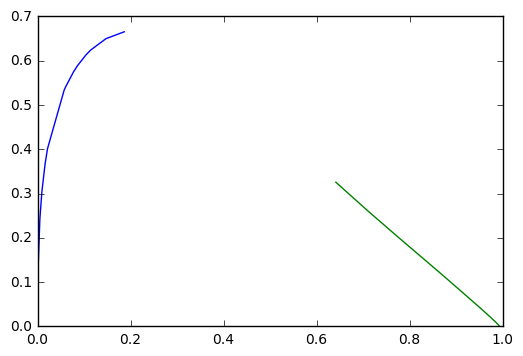

[  7.48370008e-05   5.06591277e-03   1.58933398e-02   7.70247149e-02
   7.48370011e-05   1.30276003e-03   1.14258466e-01   7.48370015e-05
   8.57318564e-02   1.86215592e-01   5.69172496e-02   1.46831071e-01
   1.03505402e-01   7.48370021e-05   7.48370030e-05   4.61002938e-03
   7.48370046e-05   8.97108921e-03   5.98194817e-02   7.48370076e-05
   2.11675160e-02]


In [68]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((bl,el),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((br,er),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)

plt.show()

print(Ly)

#now the tielines



(21,) (21,) (21,) (21,)
(13,) (13,) (8,) (8,)
(8,) (8,) (13,) (13,)


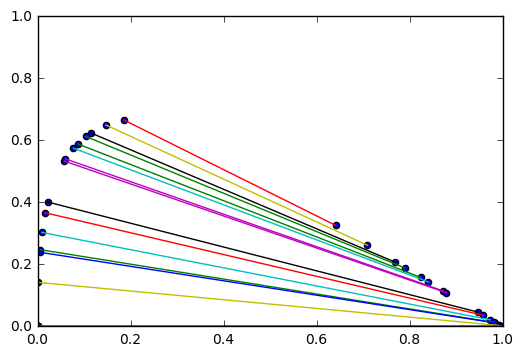

(8,)
(8,)
7.48370007603e-05 1.12524826851e-09 0.999925161874 0.993252014725
0.00506591277228 0.247727883814 0.747206203414 0.981978188027
0.015893339781 0.366775725052 0.617330935167 0.957807899682
0.0770247148998 0.574824048076 0.348151237023 0.840174686881
7.4837001084e-05 1.28648715711e-09 0.999925161712 0.993252014726
0.00130276003047 0.142079784095 0.856617455875 0.991109811995
0.114258465709 0.624348866132 0.261392668269 0.769367500288
7.48370015161e-05 1.50166323705e-09 0.999925161497 0.993252014726
0.0857318563661 0.588976022679 0.325292120962 0.823654339316
0.186215592176 0.66538571166 0.148398696183 0.641196168312
0.993252014727 7.93301104717e-12 0.0067479852654 7.48370021217e-05
0.0569172495758 0.533542016044 0.409540734381 0.878111862091
0.146831070799 0.649802893405 0.203366035582 0.708831203072
0.993252014728 9.92684879913e-12 0.00674798526246 7.48370030318e-05
0.983072114647 0.0116800538668 0.00524783148756 0.00461002938226
0.103505401612 0.612725851293 0.283768746998 0.

In [69]:
print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)

plt.axis([0,1,0,1])
#plt.scatter(d,e)
#plt.scatter(a,b)
#plt.scatter(a[np.where(a>.4)],b[np.where(a>.4)])
#plt.scatter(a[np.where(a<.4)],b[np.where(a<.4)])
#plt.scatter(d[np.where(d>.4)],e[np.where(d>.4)])
#plt.scatter(d[np.where(d<.4)],e[np.where(d<.4)])
for i in range(ndone):
    plt.plot([a[i],d[i]],[b[i],e[i]])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.show()
print(a[np.where(a>.4)].shape)
print(d[np.where(d<.4)].shape)

for i in range(ndone):
    print(a[i],b[i],c[i],d[i])